### Importance Sampling for PERT
**By Ismael Lemhadri, Sept 8, 2020**  
See Section 9.4 of [Art Owen's notes](https://drive.google.com/open?id=1_6--LPcU8CVaMlruMCZvMiReEzHqIBMq&authuser=lemisma%40alumni.stanford.edu&usp=drive_fs) for a description of the problem.  <br>

This notebook implements several approaches to importance sampling for the PERT Problem described in Art's notes.
I recommend to thoroughly read the notes before this notebook.  
The goal is to assess the probability that the completion time of the final task exceeds a given threshold. The framework is known as Program Evaluation and Review Technique or [PERT](https://en.wikipedia.org/wiki/Program_evaluation_and_review_technique).  

I tried three importance sampling ideas:
- The first approach upweights the distribution of all nodes by the same constant. 
- The second approach upweights only the nodes the critical path. 
Both approaches are described in Section 9.4 of the [notes](https://drive.google.com/open?id=1_6--LPcU8CVaMlruMCZvMiReEzHqIBMq&authuser=lemisma%40alumni.stanford.edu&usp=drive_fs).  

- The third approach is new. It extends the second one by looking not just at the first critical path but at the *distribution* of critical paths. This is meant to upweight secondary paths as well, rather than concentrating the problem onto just one path. As a consequence, the upweighted distribution and the base distribution are closer to one another and therefore a smaller sample size should be required [[Chatterjee and Diaconis, 2017](https://projecteuclid.org/euclid.aoap/1523433632)].

I evaluate the quality of the importance sampling using several metrics, including the reduction in variance and various effective sample sizes. See [Section 9.3](https://drive.google.com/open?id=1_6--LPcU8CVaMlruMCZvMiReEzHqIBMq&authuser=lemisma%40alumni.stanford.edu&usp=drive_fs) for the definition of these metrics.  
Overall, I find that the best performer is the second approach that upweights the average critical path.

![alt text](pert.png)

Figure reproduced from [Art Owen's notes](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf).

In [3]:
# define the directed graph
# parents[i] gives the list of nodes incident to node i
parents = {
    1:[],
    2:[1],
    3:[1],
    4:[2],
    5:[2],
    6:[3],
    7:[3],
    8:[3],
    9:[5,6,7],
    10:[4,8,9]
}

# define the distribution of task durations
# use the parameters from Table 9.2
thetas = {
         1:4,
         2:4,
         3:2,
         4:5,
         5:2,
         6:3,
         7:2,
         8:3,
         9:2,
        10:2}

n_nodes = len(thetas)
thetasarr = np.fromiter(thetas.values(),dtype=float)

In [528]:
def start_time(node, durations):
    # Recursive function to compute the start time for a given node
    # Returns:
#         - the start time for the node
#         - the critical path in the node up to the node
    p = parents[node]
    if p==[]:
        return 0,[node]
    else:
        stimes = [(start_time(n,durations),n) for n in p]
        # nodes are 1-indexed, but durations are 0-indexed
        etimes = [(s[0] + durations[n-1],s[1]) for s,n in stimes]
        time, path = max(etimes, key = lambda x:x[0])
        return time, path+[node]

def end_time(node, durations):
    # Compute the completion time for a given node
    stime = start_time(node, durations)
    # nodes are 1-indexed, but durations are 0-indexed
    return (stime[0] + durations[node-1],stime[1])

def simulate_pert(n_trials, durations, end_node):
    # compute the completion time for the entire PERT problem
    counts = defaultdict(int)
    etimes = np.zeros(n_trials)
    for r in range(n_trials):
        etime, path = end_time(end_node,durations[r,:])
        etimes[r] = etime
#         pathstr = '.'.join(list(map(str,path)))
#         counts[pathstr] += 1
        counts[frozenset(path)] += 1
    return etimes, counts

def print_summary_paths(counts,kappalist):
    # function to print the distribution of critical paths
    # A critical path is the random variable defined as 
    # the path in the graph that has the longest duration.
    # That is, the critical path represents the "bottleneck" tasks in the graph
    print("   Distribution of critical paths")
    t = PrettyTable(['Critical path \ Kappa'] + kappalist)
    for s in next(iter(counts.values())).keys():
        t.add_row([sorted(list(s))] + [100*counts[kappa][s]/sum(counts[kappa].values()) for kappa in kappalist])
    print(t)
    return

### Approach 0: Simulation without importance sampling

In [545]:
# Couple the simulations for Exp. distributed duration times
n_trials = 200000
base_durations = np.random.exponential(scale = 1, size = (n_trials,n_nodes)) * thetasarr
etimes_0, counts_0 = simulate_pert(n_trials, base_durations,n_nodes)

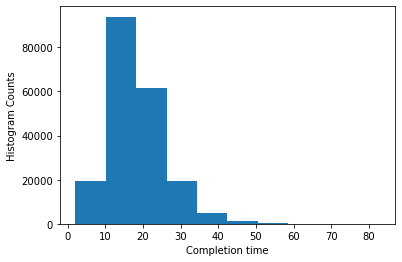

In [548]:
plt.hist(etimes_0)
plt.xlabel('Completion time')
plt.ylabel('Histogram Counts');

In [509]:
print("   Distribution of critical paths")
t = PrettyTable(['Critical path', '% times activated'])
for k,v in sorted(counts_0.items(),key=lambda x:x[1],reverse = True):
    t.add_row([sorted(list(k)), 100*v/sum(counts_0.values())])
print(t)

   Distribution of critical paths
+------------------+-------------------+
|  Critical path   | % times activated |
+------------------+-------------------+
|  [1, 2, 4, 10]   |       34.325      |
| [1, 2, 5, 9, 10] |       24.695      |
| [1, 3, 6, 9, 10] |       20.955      |
| [1, 3, 7, 9, 10] |       10.345      |
|  [1, 3, 8, 10]   |        9.68       |
+------------------+-------------------+


### Approach 1: IS with constant multiplier
We take a constant multiplier $\kappa = 4$ for all $\theta_j$'s.

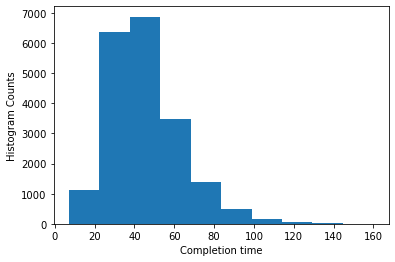

In [511]:
# illustrative example

kappa = 2.5
# use the coupling for exponential r.v.s
durations = kappa*base_durations
etimes, counts = simulate_pert(n_trials, durations,n_nodes)
# compute importance sampling weights
lambdasarr = kappa*thetasarr
is_weights = np.exp(np.sum(expon.logpdf(durations,scale=np.ones((n_trials,n_nodes))*thetasarr), axis = 1) \
- np.sum(expon.logpdf(durations,scale=np.ones((n_trials,n_nodes))*lambdasarr), axis = 1))

plt.hist(etimes)
plt.xlabel('Completion time')
plt.ylabel('Histogram Counts');

In [513]:
def IS_summary(etimes, is_weights, threshold = 70):
    n_trials = len(etimes)
    estimates = (etimes >= threshold) * is_weights
    m = np.mean(estimates)
    s = np.std(estimates)
    summary = {}
    summary['10^5 * Mean'] = 10**5 * m
    summary['10^6 * Standard error'] = 10**6 * s/np.sqrt(n_trials)
    summary['Variance reduction'] = m*(1-m)/s**2
    summary['Effective sample size [mean]'] = n_trials*np.mean(is_weights)**2/np.mean(is_weights**2)
    summary['Effective sample size [var]'] = np.sum(is_weights**2)**2/np.sum(is_weights**4)
    summary['Effective sample size [skew]'] = np.sum(is_weights**2)**3/np.sum(is_weights**3)**2
    f_weights = estimates/np.sum(estimates)
    summary['Effective sample size [function]'] = 1/np.sum(f_weights**2)
    return summary

def print_summary_kappas(obj, kappalist):
    # convenience function to summarize results from multiple IS experiments
    # each value in obj is the output of IS_summary for a different experiment
#     print("N = {} simulations\n".format(obj['n_trials']))
    print("Summary statistics for importance sampling")
    t = PrettyTable(['Kappa'] + kappalist)
    for s in next(iter(obj.values())).keys():
        t.add_row([s] + [np.round(obj[kappa][s],1) for kappa in kappalist])
    print(t)
    return

In [552]:
summaries_1 = {}
counts_1 = {}
kappalist = [2.5,3,3.5,4,4.5,5]
for kappa in kappalist:
    # use the coupling for exponential r.v.s
    durations = kappa*base_durations
    etimes, c1 = simulate_pert(n_trials, durations,n_nodes)
    counts_1[kappa] = c1
    base_scale = np.ones((n_trials,n_nodes))*thetasarr
    is_scale = np.ones((n_trials,n_nodes))*kappa*thetasarr
    is_weights = np.exp(np.sum(expon.logpdf(durations,scale=base_scale), axis = 1) \
    - np.sum(expon.logpdf(durations,scale=is_scale), axis = 1))
    summaries_1[kappa] = IS_summary(etimes, is_weights)

print_summary_kappas(summaries_1, kappalist)
print("\n")
print_summary_paths(counts_1,kappalist)

Summary statistics for importance sampling
+----------------------------------+--------+-------+-------+------+------+------+
|              Kappa               |  2.5   |   3   |  3.5  |  4   | 4.5  |  5   |
+----------------------------------+--------+-------+-------+------+------+------+
|           10^5 * Mean            |  3.4   |  3.4  |  2.9  | 3.7  | 3.0  | 2.5  |
|      10^6 * Standard error       |  2.4   |  3.2  |  2.3  | 4.1  | 3.7  | 3.0  |
|        Variance reduction        |  29.3  |  16.6 |  27.4 | 11.2 | 10.8 | 13.7 |
|   Effective sample size [mean]   | 1887.9 | 367.1 |  89.5 | 29.0 | 12.3 | 6.5  |
|   Effective sample size [var]    |  29.0  |  6.5  |  2.9  | 1.9  | 1.5  | 1.3  |
|   Effective sample size [skew]   |  57.4  |  10.4 |  4.0  | 2.3  | 1.7  | 1.4  |
| Effective sample size [function] | 196.9  | 111.6 | 161.3 | 82.8 | 64.6 | 67.7 |
+----------------------------------+--------+-------+-------+------+------+------+


   Distribution of critical paths
+-------

### Approach 2: IS with avg. critical-path multiplier
We take $ \lambda_j = \theta_j$ for $j$ not in the critical path and $\lambda_j = \kappa \theta_j$ for
$j$ in the critical path {1, 2, 4, 10}.

In [551]:
# define critical path
critical_indices = [0,1,3,9]

# run importance sampling
summaries_2 = {}
counts_2 = {}
kappalist = [3,3.5,4,4.5,5]
for kappa in kappalist:
    avg_critical_path = np.ones(n_nodes)
    avg_critical_path[critical_indices] *= kappa
    # use the coupling for exponential r.v.s to sample new durations
    durations =  avg_critical_path * base_durations
    etimes, c2 = simulate_pert(n_trials, durations,n_nodes)
    counts_2[kappa] = c2
    # compute importance sampling weights
    base_scale = (np.ones((n_trials,n_nodes))*thetasarr)[:,critical_indices]
    is_weights = np.exp(np.sum(expon.logpdf(durations[:,critical_indices],scale=base_scale) \
                               -expon.logpdf(durations[:,critical_indices],scale=kappa*base_scale), axis = 1))
#     summarize results
    summaries_2[kappa] = IS_summary(etimes, is_weights)
    
print_summary_kappas(summaries_2,kappalist)
print("\n")
print_summary_paths(counts_2,kappalist)

Summary statistics for importance sampling
+----------------------------------+---------+---------+--------+--------+--------+
|              Kappa               |    3    |   3.5   |   4    |  4.5   |   5    |
+----------------------------------+---------+---------+--------+--------+--------+
|           10^5 * Mean            |   3.2   |   3.2   |  3.3   |  3.2   |  3.2   |
|      10^6 * Standard error       |   0.4   |   0.4   |  0.4   |  0.4   |  0.4   |
|        Variance reduction        |  912.4  |  1132.0 | 875.2  | 1020.8 | 1000.1 |
|   Effective sample size [mean]   | 18986.8 | 11483.1 | 7316.3 | 4865.5 | 3352.8 |
|   Effective sample size [var]    |  3352.8 |  1735.2 | 984.0  | 600.2  | 389.0  |
|   Effective sample size [skew]   |  4719.4 |  2498.2 | 1436.7 | 882.3  | 572.1  |
| Effective sample size [function] |  5597.9 |  7022.3 | 5628.8 | 6417.1 | 6165.6 |
+----------------------------------+---------+---------+--------+--------+--------+


   Distribution of critical pat

### Approach 3: IS over the distribution of critical paths

In [549]:
# compute distribution of critical paths
paths = []
path_probs = []
for k,v in counts_0.items():
    # convert to numpy format and index nodes from 0
    paths.append(np.array(sorted(list(k))) - 1)
    path_probs.append(v)
path_probs = np.array(path_probs)/sum(path_probs)

In [550]:
# define distribution of critical paths
is_weights = np.zeros(n_trials)
durations = np.zeros((n_trials,n_nodes))
# compute cdf of critical paths
c_paths = np.random.multinomial(n_trials,path_probs)
c_paths = np.insert(0,1,np.cumsum(c_paths))

# run importance sampling
summaries_3 = {}
counts_3 = {}
kappalist = [2.5,3.5,4.5,5.5,6.5,7.5]
for kappa in kappalist:
    for critical_indices,ix,ixn in zip(paths,c_paths,c_paths[1:]):
        avg_critical_path = np.ones(n_nodes)
        avg_critical_path[critical_indices] *= kappa
        # use the coupling for exponential r.v.s to sample new durations
        durations[ix:ixn] = avg_critical_path * base_durations[ix:ixn]
        # compute importance sampling weights
        base_scale = (np.ones((ixn-ix,n_nodes))*thetasarr)[:,critical_indices]
        is_weights[ix:ixn] = np.exp(np.sum(expon.logpdf(durations[ix:ixn,critical_indices],scale=base_scale) \
                               -expon.logpdf(durations[ix:ixn,critical_indices],scale=kappa*base_scale), axis = 1))
    # run PERT
    etimes, c3 = simulate_pert(n_trials, durations,n_nodes)
    counts_3[kappa] = c3
    # summarize results
    summaries_3[kappa] = IS_summary(etimes, is_weights)
    
print_summary_kappas(summaries_3,kappalist)
print_summary_paths(counts_3, kappalist)

Summary statistics for importance sampling
+----------------------------------+---------+--------+--------+--------+-------+-------+
|              Kappa               |   2.5   |  3.5   |  4.5   |  5.5   |  6.5  |  7.5  |
+----------------------------------+---------+--------+--------+--------+-------+-------+
|           10^5 * Mean            |   7.6   |  7.8   |  5.6   |  4.5   |  3.1  |  2.2  |
|      10^6 * Standard error       |   37.2  |  39.9  |  31.1  |  21.4  |  12.3 |  6.5  |
|        Variance reduction        |   0.3   |  0.2   |  0.3   |  0.5   |  1.0  |  2.6  |
|   Effective sample size [mean]   | 25363.4 | 7366.9 | 2770.4 | 1217.4 | 584.5 | 296.5 |
|   Effective sample size [var]    |  3689.1 | 590.6  | 127.0  |  33.6  |  11.7 |  5.4  |
|   Effective sample size [skew]   |  5600.4 | 1032.3 | 258.6  |  72.6  |  23.4 |  9.4  |
| Effective sample size [function] |   4.2   |  3.8   |  3.2   |  4.4   |  6.2  |  11.9 |
+----------------------------------+---------+--------+--